# Data Driven RUL Model

In [4]:
import turbo as tb
import preprocessing as pr
import labeling as lb
import classification as cl
import rul_dataframe as rd
import plots as pl

import copy
import numpy as np
import pandas as pd

import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

Parameter

In [7]:
dataset = 4

In [8]:
tr, te, rl = tb.getTFDataset(set = dataset)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])

In [9]:
pre = pr.Preprocessing()
clf = cl.Classification()
lbl = lb.Labeling()

In [36]:
rul_df = copy.deepcopy(tr_df)
rul_df_test = copy.deepcopy(te_df)

In [37]:
clf.fit_kmeans(rul_df = rul_df, rul_df_test = rul_df_test)
pre.one_hot_encode(rul_df = rul_df)
pre.one_hot_encode(rul_df = rul_df_test)
pre.c_drop_zero_variance(rul_df = rul_df, rul_df_test = rul_df_test, c_cols = rul_df.categ_cols, eps = 0.0001)
pre.c_scale(rul_df = rul_df, rul_df_test = rul_df_test, c_cols = rul_df.categ_cols)
pre.exponential_smooth(rul_df = rul_df, alpha = 0.4)
pre.exponential_smooth(rul_df = rul_df_test, alpha = 0.4)

In [12]:
Xtr = rul_df.df[[rul_df.id_col, rul_df.time_col] + rul_df.data_cols].copy()
for i, d in Xtr.groupby(rul_df.id_col):
    quarter = int(d.shape[0] / 4) + 1
    Xtr = Xtr.drop(range(d.index[0] + quarter, d.index[-1] + 1))

train_target = torch.tensor(Xtr[rul_df.time_col].values.astype(np.float32))
train = torch.tensor(Xtr[rul_df.data_cols].values.astype(np.float32)) 
train_tensor = TensorDataset(train, train_target) 
train_loader = DataLoader(dataset = train_tensor, batch_size = 64, shuffle = True)

test_target = torch.tensor(rul_df.df[rul_df.time_col].values.astype(np.float32))
test = torch.tensor(rul_df.df[rul_df.data_cols].values.astype(np.float32)) 
test_tensor = TensorDataset(test, test_target) 
test_loader = DataLoader(dataset = test_tensor, batch_size = 64)

# Labeling Autoencoder

In [6]:
class Variational_Autoencoder(nn.Module):
    '''
    Variational Autoencoder
    '''
    def __init__(self,
                input_shape: int,
                latent_dim: int,
                hidden_dims: list = None,
                **kwars):

        super().__init__()

        self.in_shape = input_shape
        self.lat_dim = latent_dim

        if hidden_dims is None:
            hidden_dims = [input_shape]

        layers = []
        for d in hidden_dims:
            layers.append(
                nn.Sequential(
                    nn.Linear(in_features = input_shape,
                                out_features = d),
                    nn.Sigmoid())
            )
            input_shape = d

        self.encoder = nn.Sequential(*layers)
        self.mu_encoder = nn.Linear(in_features = hidden_dims[-1],
                                    out_features = latent_dim)
        self.var_encoder = nn.Linear(in_features = hidden_dims[-1],
                                    out_features = latent_dim)
        
        layers = []
        input_shape = latent_dim
        hidden_dims.reverse()
        for d in hidden_dims:
            layers.append(
                nn.Sequential(
                    nn.Linear(in_features = input_shape,
                                out_features = d),
                    nn.Sigmoid())
            )
            input_shape = d

        self.decoder = nn.Sequential(*layers,
                        nn.Linear(in_features = input_shape,
                                    out_features = self.in_shape),
                        nn.ReLU())
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, features):
        x = self.encoder(features)
        mu = self.mu_encoder(x)
        var = self.var_encoder(x)

        code = self.reparameterize(mu = mu, logvar = var)
        
        reconstructed = self.decoder(code)
        reconstructed = torch.relu(reconstructed)
        return reconstructed

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Variational_Autoencoder(input_shape = len(rul_df.data_cols), latent_dim = 8, hidden_dims=[11,11]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()

In [25]:
epochs = 15
model.train()

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/15, loss = 0.477834
epoch : 2/15, loss = 0.432068
epoch : 3/15, loss = 0.431959
epoch : 4/15, loss = 0.431722
epoch : 5/15, loss = 0.430758
epoch : 6/15, loss = 0.427026
epoch : 7/15, loss = 0.425202
epoch : 8/15, loss = 0.424934
epoch : 9/15, loss = 0.424770
epoch : 10/15, loss = 0.424299
epoch : 11/15, loss = 0.421181
epoch : 12/15, loss = 0.420792
epoch : 13/15, loss = 0.420682
epoch : 14/15, loss = 0.420544
epoch : 15/15, loss = 0.420431


In [47]:
model.eval()
error = []
with torch.no_grad():
    for batch_features, _ in test_loader:
        outputs = model(batch_features)
        for i in range(batch_features.size()[0]):
            error.append(criterion(outputs[i], batch_features[i]).item())   

In [48]:
rul_df.df['bae'] = error
rul_df.label_cols.append('bae')

In [38]:
testtest_target = torch.tensor(rul_df_test.df[rul_df_test.time_col].values.astype(np.float32))
testtest = torch.tensor(rul_df_test.df[rul_df_test.data_cols].values.astype(np.float32)) 
testtest_tensor = TensorDataset(testtest, testtest_target) 
testtest_loader = DataLoader(dataset = testtest_tensor, batch_size = 64)

In [39]:
for batch_idx, data in enumerate(test_loader):
    print('batch {}, x shape {}, y shape {}'.format(batch_idx, data[0].shape, data[1].shape))

batch 0, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 1, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 2, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 3, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 4, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 5, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 6, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 7, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 8, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 9, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 10, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 11, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 12, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 13, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 14, x shape torch.Size([64, 16]), y shape torch.Size([64])
batch 15, x shape torch.Size([64, 1

In [40]:
model.eval()
error = []
with torch.no_grad():
    for batch_features, _ in testtest_loader:
        outputs = model(batch_features)
        for i in range(batch_features.size()[0]):
            error.append(criterion(outputs[i], batch_features[i]).item()) 

In [41]:
rul_df_test.df['bae'] = error
rul_df_test.label_cols.append('bae')

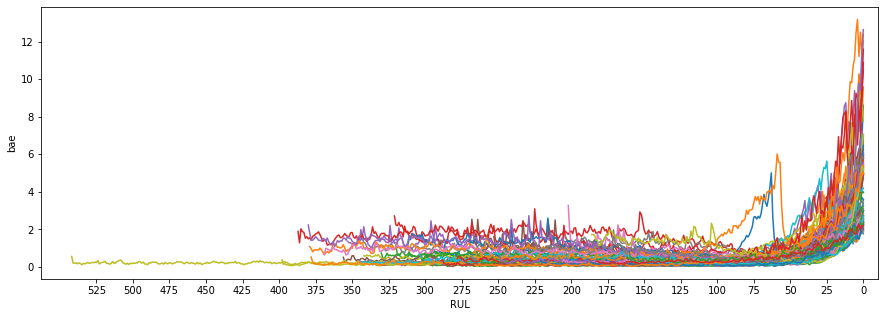

In [28]:
plt = pl.Plots(rul_df = rul_df)
plt.reversetimeplot_column('bae', mod = 2)

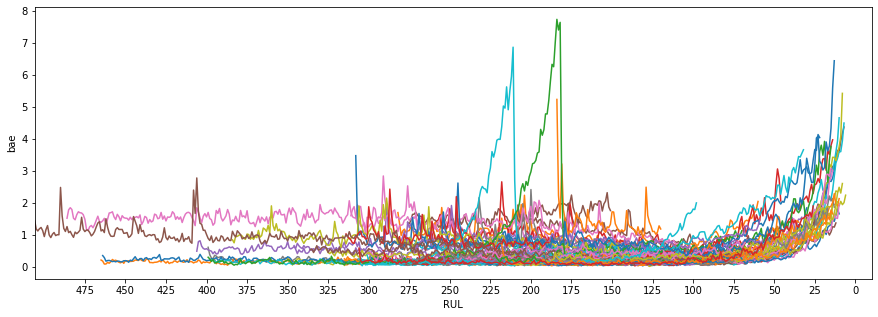

In [42]:
plt = pl.Plots(rul_df = rul_df_test)
plt.reversetimeplot_column('bae', mod = 2)

In [49]:
scale_col = lambda x: (x - x.min()) / (x.max() - x.min())
rul_df.df['bae'] = rul_df.df[[rul_df.id_col, 'bae']].groupby(rul_df.id_col).transform(scale_col)
rul_df_test.df['bae'] = rul_df_test.df[[rul_df_test.id_col, 'bae']].groupby(rul_df_test.id_col).transform(scale_col)
rul_df.df['cbae'] = rul_df.df[[rul_df.id_col, 'bae']].groupby(rul_df.id_col).cumsum()
rul_df_test.df['cbae'] = rul_df_test.df[[rul_df_test.id_col, 'bae']].groupby(rul_df_test.id_col).cumsum()
rul_df.df['cbae'] = rul_df.df[[rul_df.id_col, 'cbae']].groupby(rul_df.id_col).transform(scale_col)
rul_df_test.df['cbae'] = rul_df_test.df[[rul_df_test.id_col, 'cbae']].groupby(rul_df_test.id_col).transform(scale_col)

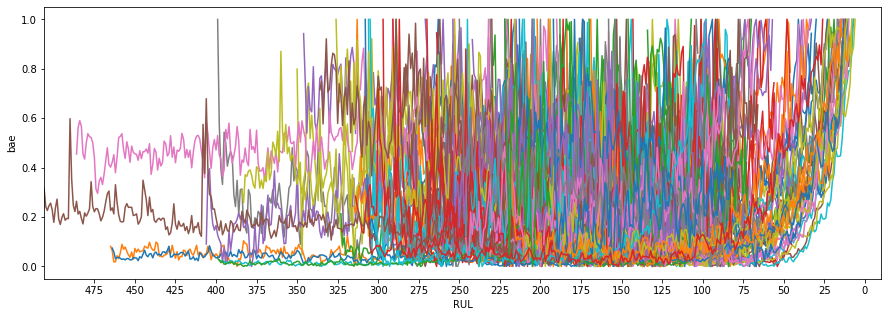

In [51]:
plt.reversetimeplot_column('bae', mod = 2)